In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def calculate_eddy(width=500000, num_depth_layers=21, eta0=1, L=1e5, H=1000, a=1, b=1, rho0=1025, 
                                            f0=None, alpha_1=0., alpha_2=0., T0=20, dTdz=0.005, dSdz=0.01, taper_depth=None):
    """
    Calculate the 3D geostrophic velocity components U, V, density anomaly sigma, temperature, salinity, 
    and pressure fields for an ocean eddy.

    Parameters:
    - width: Horizontal extent of the grid (eddy scale) in meters.
    - num_depth_layers: Number of vertical layers (depth resolution).
    - eta0: Surface elevation perturbation.
    - L: Horizontal length scale of the eddy in meters.
    - H: Vertical depth scale of the eddy in meters.
    - a, b: Coefficients affecting density anomaly variation.
    - rho0: Reference density (kg/m^3).
    - f0: Coriolis parameter. If None, it will be calculated based on a latitude of -34 degrees.
    - alpha_1, alpha_2: Coefficients affecting eddy center shift with depth.
    - T0: Surface temperature (degrees Celsius).
    - dTdz: Temperature gradient with depth (degrees Celsius per meter).
    - dSdz: Salinity gradient with depth (psu per meter).
    - taper_depth: Tapering scale for vertical variations.

    Returns:
    - U, V: 3D matrices for the U and V (x- and y-components) velocity fields.
    - sigma: 3D matrix for the density anomaly.
    - T: 3D matrix for the temperature field.
    - S: 3D matrix for the salinity field.
    - P: 3D matrix for the pressure field.
    - x, y, z: Horizontal and vertical grid points.
    """

    # Constants
    if f0 is None:
        f0 = 2 * 7.29E-5 * np.sin(np.radians(-34))  # Coriolis parameter for latitude -34 degrees
    g = 9.81  # Gravitational acceleration (m/s^2)

    # Create 2D meshgrid for horizontal space (x, y) and depth (z)
    x = np.linspace(-width // 2, width // 2, 101)  # x-coordinates
    y = np.linspace(-width // 2, width // 2, 101)  # y-coordinates
    z = np.linspace(-H, 0, num_depth_layers)  # Depth levels from surface (0) to -H

    # Create 3D meshgrid
    x_3d, y_3d, z_3d = np.meshgrid(x, y, z, indexing='ij')

    if taper_depth is None:
        taper_factor = np.ones_like(z_3d)
    else:
        taper_factor = np.exp(z_3d / taper_depth)

    # Define the functions f(|r - r_c(z)|) and g(z)
    def f_r_rc(r, L):
        return np.exp(-r**2 / L**2)

    # Calculate the center position as a function of depth
    x_c = alpha_1 * z_3d
    y_c = alpha_2 * z_3d

    # Calculate radial distance r - r_c(z)
    r_c = np.hypot( x_3d - x_c, y_3d - y_c )

    # Temperature field
    # T = T0 + dTdz * z_3d - 2 * f_r_rc(r_c, L) * taper_factor
    T = - 2 * f_r_rc(r_c, L) * taper_factor

    # Salinity field
    S0 = 35  # Reference surface salinity (psu)
    # S = S0 + dSdz * z_3d + 1.5 * f_r_rc(r_c, L) * taper_factor
    S = 1.5 * f_r_rc(r_c, L) * taper_factor

    # Pressure field (hydrostatic pressure)
    P = -rho0 * g * z_3d

    # Density field using a simplified equation of state
    alpha = 0.0002  # Thermal expansion coefficient (1/°C)
    beta = 0.0008  # Haline contraction coefficient (1/psu)
    sigma = rho0 * (1 - alpha * (T - T0) + beta * (S - S0)) 
    sigma -= np.mean(sigma)

    # Calculate geostrophic velocity components
    dx = x[1] - x[0]  # Grid spacing in x
    dy = y[1] - y[0]  # Grid spacing in y
    d_sigma_dx = np.gradient(sigma, axis=0) / dx
    d_sigma_dy = np.gradient(sigma, axis=1) / dy

    U = g / f0 * d_sigma_dy * taper_factor
    V = -g / f0 * d_sigma_dx * taper_factor

    U = np.flip(U, axis=2)
    V = np.flip(V, axis=2)
    sigma = np.flip(sigma, axis=2)
    T = np.flip(T, axis=2)
    S = np.flip(S, axis=2)
    P = np.flip(P, axis=2)
    z = np.flip(z)

    return U, V, sigma, T, S, P, x, y, z


In [3]:
U, V, sigma, T, S, P, x, y, z = calculate_eddy(taper_depth=None)

U_tap, V_tap, sigma_tap, T_tap, S_tap, P_tap, _, _, _ = calculate_eddy(taper_depth=400)

dx, dy, dz = x[1] - x[0], y[1] - y[0], z[1]-z[0]

alpha_1 = dx / dz # tilt in x direction

U_tilt, V_tilt, sigma_tilt, T_tilt, S_tilt, P_tilt, _, _, _ = calculate_eddy(taper_depth=None, alpha_1=alpha_1)

U_tilt_tap, V_tilt_tap, sigma_tilt_tap, T_tilt_tap, S_tilt_tap, P_tilt_tap, _, _, _ = calculate_eddy(taper_depth=400, alpha_1=alpha_1)


In [4]:
modelled_data = {
    'Eddy0':{
        'Name': 'E1', 'U': U, 'V': V, 'sigma': sigma, 'T': T, 'S': S, 'P': P
    },
    'Eddy1':{
        'Name': r'E1$_\text{tap}$', 'U': U_tap, 'V': V_tap, 'sigma': sigma_tap, 'T': T_tap, 'S': S_tap, 'P': P_tap
    },
    'Eddy2':{
        'Name': 'E2', 'U': U_tilt, 'V': V_tilt, 'sigma': sigma_tilt, 'T': T_tilt, 'S': S_tilt, 'P': P_tilt
    },
    'Eddy3':{
        'Name': r'E2$_\text{tap}$', 'U': U_tilt_tap, 'V': V_tilt_tap, 'sigma': sigma_tilt_tap, 'T': T_tilt_tap, 'S': S_tilt_tap, 'P': P_tilt_tap
    },
    'x': x, 'y': y, 'z': z
}
eddies = ['Eddy0', 'Eddy1', 'Eddy2', 'Eddy3']

In [5]:
model_result_data = pd.DataFrame(columns=['Eddy', 'z', 'xc', 'yc', 'Depth', 'Vort'])

x, y = modelled_data['x'], modelled_data['y']
X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

for eddy in eddies:
    
    U, V = modelled_data[eddy]['U'], modelled_data[eddy]['V']
    xc_pre, yc_pre = 0, 0
    nic, njc = U.shape[0] // 2, U.shape[1] // 2

    for depth_lvl in range(U.shape[-1]):

        # Find nencioli
        u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
        
        # Fit cubic and tangent
        def fit_cubic_and_tangent(x, y):
            cubic = np.poly1d(np.polyfit(x, y, 3))
            cubic_deriv = np.polyder(cubic)
            roots = np.roots(cubic)
            valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
        
            if valid_roots.size:
                R = np.abs(valid_roots-x[len(x)//2])
                root = valid_roots[R==np.min(R)][0]
                slope = cubic_deriv(root)
                intercept = -slope * root
            else:
                slope = 0
                roots = np.roots(cubic_deriv)
                valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
                if valid_roots.size:
                    R = np.abs(valid_roots-x[len(x)//2])
                    root = valid_roots[R==np.min(R)]
                    intercept = cubic(root)
                else:
                    intercept = np.mean(y)
        
            tangent_line = slope * x + intercept
            sst = np.sum((y - np.mean(y))**2)
            sse = np.sum((y - tangent_line)**2)
            
            if sst == 0 and sse == 0:
                r_squared = 1
            else:
                r_squared = 1 - (sse / sst)
                
            return slope, intercept, r_squared
        
        # Plot fits
        def extend_indices(arr, start_idx, r):
            indices = [start_idx]
            idx = start_idx
            i = 0
            while idx > 0 and not np.isnan(arr[idx - 1]):
                idx -= 1
                indices.insert(0, idx)
                if i > r:
                    break
                i += 1
            idx = start_idx
            i = 0
            while idx < len(arr) - 1 and not np.isnan(arr[idx + 1]):
                idx += 1
                indices.append(idx)
                if i > r:
                    break
                i += 1
            return indices

        r = 25 # 
        indices_1 = extend_indices(u[:, njc], nic, r)
        indices_2 = extend_indices(u[nic, :], njc, r)
        u1 = u[indices_1, njc]
        v1 = v[indices_1, njc]
        u2 = u[nic, indices_2]
        v2 = v[nic, indices_2]
        xx = x[indices_1] / 1000
        yy = y[indices_2] / 1000
                    
        # Calculate resultsresult_data = pd.DataFrame(columns=['Eddy', 'z', 'xc', 'yc', 'Depth', 'Vort'])

x, y = modelled_data['x'], modelled_data['y']
X, Y, dx = *np.meshgrid(x, y), x[1]-x[0]

for eddy in eddies:
    
    U, V = modelled_data[eddy]['U'], modelled_data[eddy]['V']
    xc_pre, yc_pre = 0, 0
    nic, njc = U.shape[0] // 2, U.shape[1] // 2

    for depth_lvl in range(U.shape[-1]):

        # Find nencioli
        u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
        
        # Fit cubic and tangent
        def fit_cubic_and_tangent(x, y):
            cubic = np.poly1d(np.polyfit(x, y, 3))
            cubic_deriv = np.polyder(cubic)
            roots = np.roots(cubic)
            valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
        
            if valid_roots.size:
                R = np.abs(valid_roots-x[len(x)//2])
                root = valid_roots[R==np.min(R)][0]
                slope = cubic_deriv(root)
                intercept = -slope * root
            else:
                slope = 0
                roots = np.roots(cubic_deriv)
                valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
                if valid_roots.size:
                    R = np.abs(valid_roots-x[len(x)//2])
                    root = valid_roots[R==np.min(R)]
                    intercept = cubic(root)
                else:
                    intercept = np.mean(y)
        
            tangent_line = slope * x + intercept
            sst = np.sum((y - np.mean(y))**2)
            sse = np.sum((y - tangent_line)**2)
            
            if sst == 0 and sse == 0:
                r_squared = 1
            else:
                r_squared = 1 - (sse / sst)
                
            return slope, intercept, r_squared
        
        # Plot fits
        def extend_indices(arr, start_idx, r):
            indices = [start_idx]
            idx = start_idx
            i = 0
            while idx > 0 and not np.isnan(arr[idx - 1]):
                idx -= 1
                indices.insert(0, idx)
                if i > r:
                    break
                i += 1
            idx = start_idx
            i = 0
            while idx < len(arr) - 1 and not np.isnan(arr[idx + 1]):
                idx += 1
                indices.append(idx)
                if i > r:
                    break
                i += 1
            return indices

        r = 25 # 
        indices_1 = extend_indices(u[:, njc], nic, r)
        indices_2 = extend_indices(u[nic, :], njc, r)
        u1 = u[indices_1, njc]
        v1 = v[indices_1, njc]
        u2 = u[nic, indices_2]
        v2 = v[nic, indices_2]
        xx = x[indices_1] / 1000
        yy = y[indices_2] / 1000
                    
        # Calculate results
        A1, A0, r2A = fit_cubic_and_tangent(xx, u1)
        B1, B0, r2B = fit_cubic_and_tangent(xx, v1)
        C1, C0, r2C = fit_cubic_and_tangent(yy, u2)
        D1, D0, r2D = fit_cubic_and_tangent(yy, v2)
        
        alpha = A0 if r2A < r2B else C0
        beta = B0 if r2B < r2D else D0
        gamma = A1 if r2A < r2D else -D1
        q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                    
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
        w = 2 * (q11 + q22)

        xc_pre, yc_pre = xc, yc

        # R = np.hypot(xc - xc_pre, yc - yc_pre)
        # if R < 100000:

        model_result_data.loc[len(model_result_data)] = {
            'Eddy': eddy,
            'z': depth_lvl,
            'xc': xc,
            'yc': yc,
            'Depth': z[depth_lvl],
            'Vort': w
        }
        # else:
        #     breakresult_data
        A1, A0, r2A = fit_cubic_and_tangent(xx, u1)
        B1, B0, r2B = fit_cubic_and_tangent(xx, v1)
        C1, C0, r2C = fit_cubic_and_tangent(yy, u2)
        D1, D0, r2D = fit_cubic_and_tangent(yy, v2)
        
        alpha = A0 if r2A < r2B else C0
        beta = B0 if r2B < r2D else D0
        gamma = A1 if r2A < r2D else -D1
        q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                    
        yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
        xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
        w = 2 * (q11 + q22)

        xc_pre, yc_pre = xc, yc

        # R = np.hypot(xc - xc_pre, yc - yc_pre)
        # if R < 100000:

        model_result_data.loc[len(model_result_data)] = {
            'Eddy': eddy,
            'z': depth_lvl,
            'xc': xc,
            'yc': yc,
            'Depth': z[depth_lvl],
            'Vort': w
        }
        # else:
        #     break

In [6]:
model_result_data

,Eddy,z,xc,yc,Depth,Vort
0,Eddy0,0,0.0,0.0,0.0,-0.062713
1,Eddy0,0,0.0,0.0,0.0,-0.062713
2,Eddy0,1,0.0,0.0,-50.0,-0.062713
3,Eddy0,1,0.0,0.0,-50.0,-0.062713
4,Eddy0,2,0.0,0.0,-100.0,-0.062713
...,...,...,...,...,...,...
163,Eddy3,18,97.775519,0.0,-900.0,-0.000606
164,Eddy3,19,101.765757,0.0,-950.0,-0.000479
165,Eddy3,19,101.765757,0.0,-950.0,-0.000479
166,Eddy3,20,105.638999,0.0,-1000.0,-0.000377


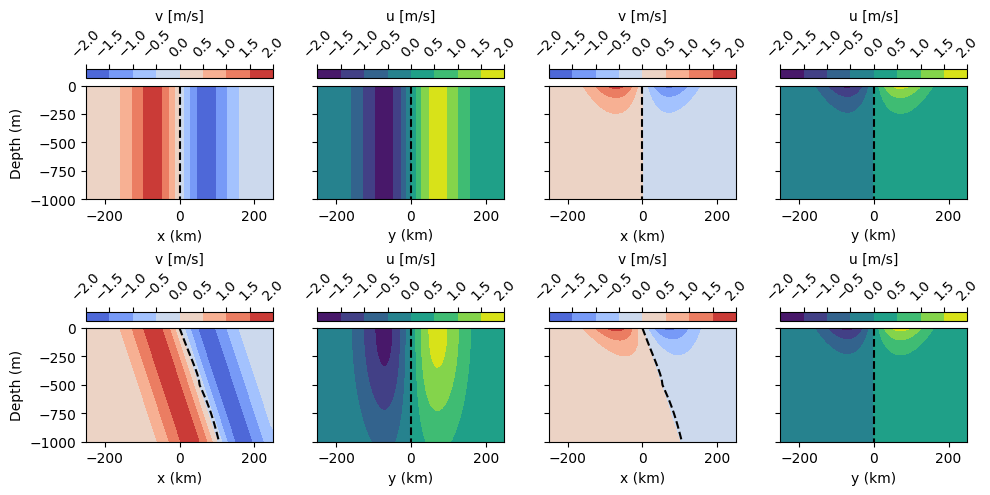

In [7]:
fig, axs = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
x = modelled_data['x']/1000
y = modelled_data['y']/1000
for i, ax_pair in enumerate(axs.reshape(-1, 2)):
    eddy = eddies[i]
    U = modelled_data[eddy]['U'][modelled_data[eddy]['U'].shape[0] // 2, :, :]
    V = modelled_data[eddy]['V'][:, modelled_data[eddy]['V'].shape[1] // 2, :]

    im1 = ax_pair[0].contourf(x, z, V.T, cmap='coolwarm')
    im2 = ax_pair[1].contourf(y, z, U.T)

    df = model_result_data[model_result_data['Eddy'] == eddy].drop(columns='Eddy').set_index('z')

    VORT_THRESH = -0.003250 #-0.000006
    mask = df['Vort'] <= VORT_THRESH
    mask = mask.tolist()
    for i in range(len(mask) - 2, -1, -1):
        if mask[i] and not mask[i + 1]:
            mask[i + 1] = True
            break
    mask = pd.Series(mask)
    ax_pair[0].plot(df.loc[mask, 'xc'], df.loc[mask, 'Depth'], 'k', label='VG', alpha=1, linestyle='--')
    ax_pair[0].plot(df.loc[~mask, 'xc'], df.loc[~mask, 'Depth'], 'k', alpha=0.5, linestyle='--')
    ax_pair[1].plot(df.loc[mask, 'yc'], df.loc[mask, 'Depth'], 'k', label='VG', alpha=1, linestyle='--')
    ax_pair[1].plot(df.loc[~mask, 'yc'], df.loc[~mask, 'Depth'], 'k', alpha=0.5, linestyle='--')
        
    ax_pair[0].set_xlabel('x (km)')
    ax_pair[1].set_xlabel('y (km)')

    cbar1 = fig.colorbar(im1, ax=ax_pair[0], orientation='horizontal', location='top', label='v [m/s]')
    cbar2 = fig.colorbar(im2, ax=ax_pair[1], orientation='horizontal', location='top', label='u [m/s]')

    # Rotate colorbar ticks
    cbar1.ax.tick_params(axis='x', rotation=45)
    cbar2.ax.tick_params(axis='x', rotation=45)

axs[0, 0].set_ylabel('Depth (m)')
axs[1, 0].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()


In [8]:
df = model_result_data[model_result_data['Eddy'] == eddy].drop(columns='Eddy').set_index('z')


In [9]:
mask = df['Vort'] <= VORT_THRESH

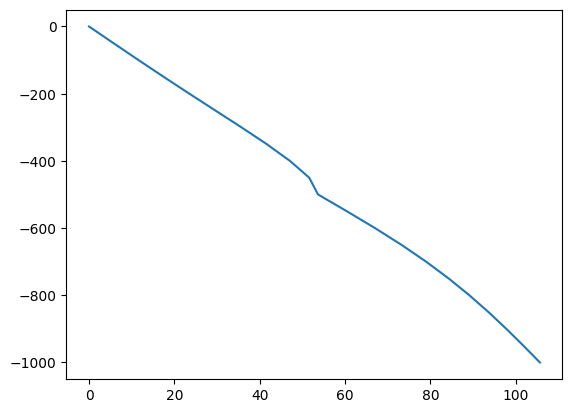

In [10]:
plt.plot(df['xc'], df['Depth'])

In [11]:
def vis_model(eddy, depth_lvl):
    
    U, V = modelled_data[eddy]['U'], modelled_data[eddy]['V']
    x, y = modelled_data['x'], modelled_data['y']
    
    # Find nencioli
    u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]

    nic, njc = u.shape[0] // 2, u.shape[1] // 2

    
    # Fit cubic and tangent
    def fit_cubic_and_tangent(x, y):
        cubic = np.poly1d(np.polyfit(x, y, 3))
        cubic_deriv = np.polyder(cubic)
        roots = np.roots(cubic)
        valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
    
        if valid_roots.size:
            R = np.abs(valid_roots-x[len(x)//2])
            root = valid_roots[R==np.min(R)]
            slope = cubic_deriv(root)
            intercept = -slope * root
        else:
            slope = 0
            roots = np.roots(cubic_deriv)
            valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
            if valid_roots.size:
                R = np.abs(valid_roots-x[len(x)//2])
                root = valid_roots[R==np.min(R)]
                intercept = cubic(root)
            else:
                intercept = np.mean(y)
    
        tangent_line = slope * x + intercept
        sst = np.sum((y - np.mean(y))**2)
        sse = np.sum((y - tangent_line)**2)
        if sst == 0 and sse == 0:
            r_squared = 1
        else:
            r_squared = 1 - (sse / sst)

        return slope, intercept, r_squared
    
    # Plot fits
    def extend_indices(arr, start_idx, r):
        indices = [start_idx]
        idx = start_idx
        i = 0
        while idx > 0 and not np.isnan(arr[idx - 1]):
            idx -= 1
            indices.insert(0, idx)
            if i > r:
                break
            i += 1
        idx = start_idx
        i = 0
        while idx < len(arr) - 1 and not np.isnan(arr[idx + 1]):
            idx += 1
            indices.append(idx)
            if i > r:
                break
            i += 1
        return indices
    
    r = 25 # 
    indices_1 = extend_indices(u[:, njc], nic, r)
    indices_2 = extend_indices(u[nic, :], njc, r)
    u1 = u[indices_1, njc]
    v1 = v[indices_1, njc]
    u2 = u[nic, indices_2]
    v2 = v[nic, indices_2]
    xx = x[indices_1] / 1000
    yy = y[indices_2] / 1000
    
    fig, axs = plt.subplots(1, 4, figsize=(28, 7))
    datasets = [(xx, u1, 'u1'),
                (xx, v1, 'v1'),
                (yy, u2, 'u2'),
                (yy, v2, 'v2')]
    
    for ax, (l, vel, label) in zip(axs, datasets):
        slope, intercept, r2 = fit_cubic_and_tangent(l, vel)
        l_fine = np.linspace(l.min(), l.max(), 500)
        ax.plot(l, vel, 'o', label=f'Original {label} data')
        ax.plot(l_fine, np.poly1d(np.polyfit(l, vel, 3))(l_fine), '-', label=f'Cubic fit for {label}')
        ax.plot(l_fine, slope * l_fine + intercept, '--', label=f'R2={r2:.2f}')
        ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=.5)
        ax.set_xlabel('x' if '1' in label else 'y')
        ax.set_ylabel(label)
        ax.legend()
    plt.tight_layout()
    plt.show()
    
    A1, A0, r2A = fit_cubic_and_tangent(xx, u1)
    B1, B0, r2B = fit_cubic_and_tangent(xx, v1)
    C1, C0, r2C = fit_cubic_and_tangent(yy, u2)
    D1, D0, r2D = fit_cubic_and_tangent(yy, v2)
    
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    
    yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
    xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
    w = 2 * (q11 + q22)
    
    # Plot results
    spacing = 5
    plt.quiver(X[::spacing, ::spacing]/1000, Y[::spacing, ::spacing]/1000, u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)

    plt.plot(xx, [0]*len(xx), 'r', zorder=1, alpha=.5)
    plt.plot([0]*len(yy), yy, 'r', zorder=1, alpha=.5)

    plt.scatter(xc, yc, color='r', marker='x', s=100, label='MOCA')
    plt.legend()
    print(xc, yc)

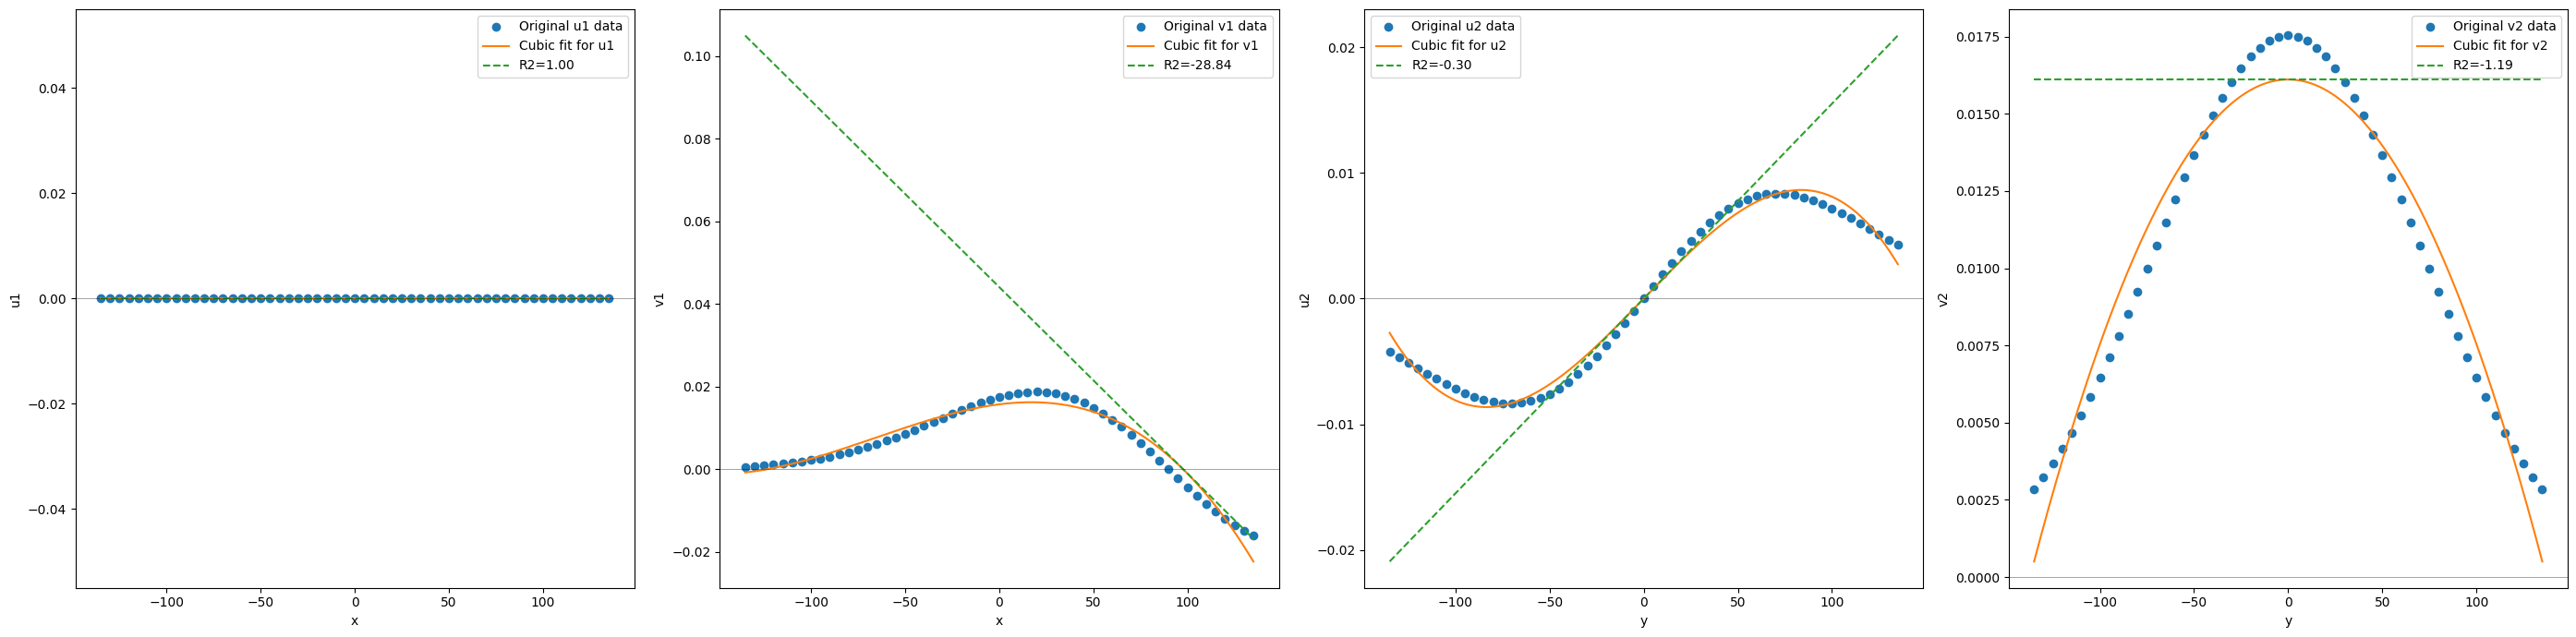

[97.77551933] [2.68949637e-15]


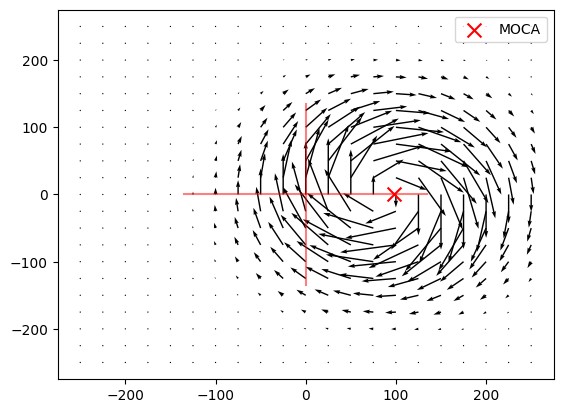

In [12]:
vis_model('Eddy3', 18)

## Real Eddies

In [13]:
import pickle
with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('/home/z5297792/UNSW-MRes/MRes/Climatology/ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

with open('/srv/scratch/z5297792/Sample/frontier_sample_data.pkl', 'rb') as file:
    sample_data = pickle.load(file)
the_frontier_eddies = list(sample_data.keys())

In [14]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import time

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
f  = dataset.variables['f'][:]
f = np.transpose(f, axes=(1, 0))
h = dataset.variables['h'][:]
h = np.transpose(h, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))

import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

In [133]:
result_data = pd.DataFrame(columns=['Eddy', 'Day', 'z', 'xc', 'yc', 'Depth', 'Vort'])

for eddy in the_frontier_eddies:
    
    for t in range(30):

        U, V = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V']
        x, y = sample_data[eddy][f'T{t}']['x'], sample_data[eddy][f'T{t}']['y']
        X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
        xc_pre, yc_pre = 0, 0
        nic, njc = U.shape[0] // 2, U.shape[1] // 2
        
        for depth_lvl in range(U.shape[-1]):
    
            # Find nencioli
            u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]
            
            # Fit cubic and tangent
            def fit_cubic_and_tangent(x, y):
                cubic = np.poly1d(np.polyfit(x, y, 3))
                cubic_deriv = np.polyder(cubic)
                roots = np.roots(cubic)
                valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
            
                if valid_roots.size:
                    R = np.abs(valid_roots-x[len(x)//2])
                    root = valid_roots[R==np.min(R)][0]
                    slope = cubic_deriv(root)
                    intercept = -slope * root
                else:
                    slope = 0
                    roots = np.roots(cubic_deriv)
                    valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
                    if valid_roots.size:
                        R = np.abs(valid_roots-x[len(x)//2])
                        root = valid_roots[R==np.min(R)]
                        intercept = cubic(root)
                    else:
                        intercept = np.mean(y)
            
                # tangent_line = slope * x + intercept
                # sst = np.sum((y - np.mean(y))**2)
                # sse = np.sum((y - tangent_line)**2)
        
                sst = np.sum((y - np.mean(y))**2)
                sse = np.sum((y - cubic(x))**2)  # Use cubic(x) instead of tangent_line
        
                r_squared = 1 if (sst == 0 and sse == 0) else 1 - (sse / sst)
                    
                return slope, intercept, r_squared
            
            # # Plot fits
            # def extend_indices(arr, start_idx, r):
            #     indices = [start_idx]
            #     idx = start_idx
            #     i = 0
            #     while idx > 0 and not np.isnan(arr[idx - 1]):
            #         idx -= 1
            #         indices.insert(0, idx)
            #         if i > r:
            #             break
            #         i += 1
            #     idx = start_idx
            #     i = 0
            #     while idx < len(arr) - 1 and not np.isnan(arr[idx + 1]):
            #         idx += 1
            #         indices.append(idx)
            #         if i > r:
            #             break
            #         i += 1
            #     return indices
    
            # r = 20 # 
            # indices_1 = extend_indices(u[:, njc], nic, r)
            # indices_2 = extend_indices(u[nic, :], njc, r)

            r = 20
            ni_min, ni_max = max(0, nic - r), min(u.shape[0], nic + r + 1)
            nj_min, nj_max = max(0, njc - r), min(u.shape[1], njc + r + 1)
            
            u1, v1 = u[ni_min:ni_max, njc], v[ni_min:ni_max, njc]
            u2, v2 = u[nic, nj_min:nj_max], v[nic, nj_min:nj_max]
            
            xx, yy = x[ni_min:ni_max], y[nj_min:nj_max]
            
            mask_1, mask_2 = ~np.isnan(u1), ~np.isnan(u2)
            
            xx, yy = xx[mask_1] / 1000, yy[mask_2] / 1000
            u1, v1, u2, v2 = u1[mask_1], v1[mask_1], u2[mask_2], v2[mask_2]

            if len(u1) == 0 or len(u2) == 0:
                break

            # Calculate results
            A1, A0, r2A = fit_cubic_and_tangent(xx, u1)
            B1, B0, r2B = fit_cubic_and_tangent(xx, v1)
            C1, C0, r2C = fit_cubic_and_tangent(yy, u2)
            D1, D0, r2D = fit_cubic_and_tangent(yy, v2)
            
            alpha = A0 if r2A < r2B else C0
            beta = B0 if r2B < r2D else D0
            gamma = A1 if r2A < r2D else -D1
            q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
                        
            yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))
            xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))
            w = 2 * (q11 + q22)
    
            R = np.hypot(xc - xc_pre, yc - yc_pre)
            if R < 100 and np.abs(w) > 0.007 and np.sign(w) == np.sign(eddies[eddy].iloc[0]['Vort']):
    
                result_data.loc[len(result_data)] = {
                    'Eddy': eddy,
                    'Day': t,
                    'z': depth_lvl,
                    'xc': xc,
                    'yc': yc,
                    'Depth': z_r[150, 150, depth_lvl],
                    'Vort': w
                }
                xc_pre, yc_pre = xc, yc
            else:
                break



In [134]:
result_data

,Eddy,Day,z,xc,yc,Depth,Vort
0,Eddy790,0,0,9.256063,0.581965,-1.783320,0.036809
1,Eddy790,0,1,8.050036,1.399079,-5.879627,0.036619
2,Eddy790,0,2,7.231026,1.731353,-10.725783,0.036512
3,Eddy790,0,3,6.303389,1.837191,-16.383097,0.036450
4,Eddy790,0,4,5.318629,1.762514,-22.925581,0.036396
...,...,...,...,...,...,...,...
2563,Eddy775,29,15,5.925573,-2.382553,-218.754856,-0.011024
2564,Eddy775,29,16,5.841501,-2.446538,-266.206398,-0.009975
2565,Eddy775,29,17,5.656063,-2.251783,-327.440851,-0.009099
2566,Eddy775,29,18,6.396407,-2.391454,-407.922192,-0.008344


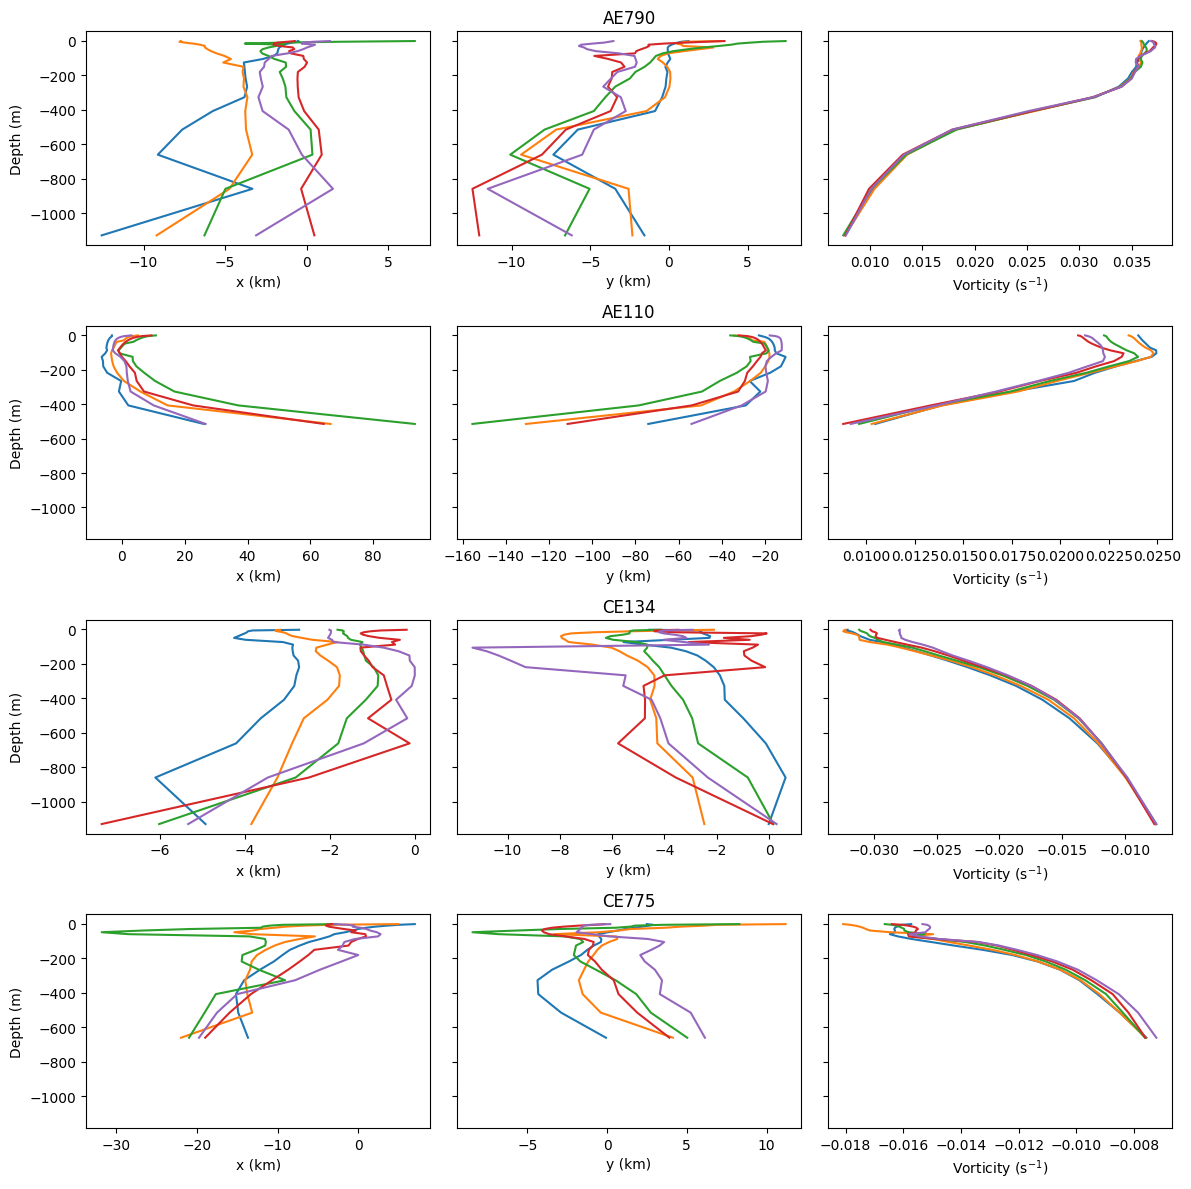

In [136]:
fig, axs = plt.subplots(4, 3, figsize=(12, 12), sharey=True)  
for r, eddy in enumerate(the_frontier_eddies):
    for t in range(5,10):
        df = result_data[(result_data['Eddy'] == eddy) & (result_data['Day'] == t)].drop(columns='Eddy').set_index('z')
        axs[r,0].plot(df['xc'], df['Depth'])
        # axs[r,0].plot(df['xc'], df.index)
        axs[r,0].set_xlabel('x (km)')
        axs[r,0].set_ylabel('Depth (m)')
        axs[r,1].plot(df['yc'],df['Depth'])
        # axs[r,1].plot(df['yc'], df.index)
        axs[r,1].set_xlabel('y (km)')
        axs[r,1].set_title('AE' + str(extract_number(eddy)) if eddies[eddy].iloc[0]['Vort'] > 0 else 'CE' + str(extract_number(eddy)))
        axs[r,2].plot(df['Vort'], df['Depth'])
        # axs[r,2].plot(df['Vort'], df.index)
        axs[r,2].set_xlabel(r'Vorticity (s$^{-1}$)')
        # axs[r,2].set_ylabel('Depth (m)')

plt.tight_layout()
plt.show()


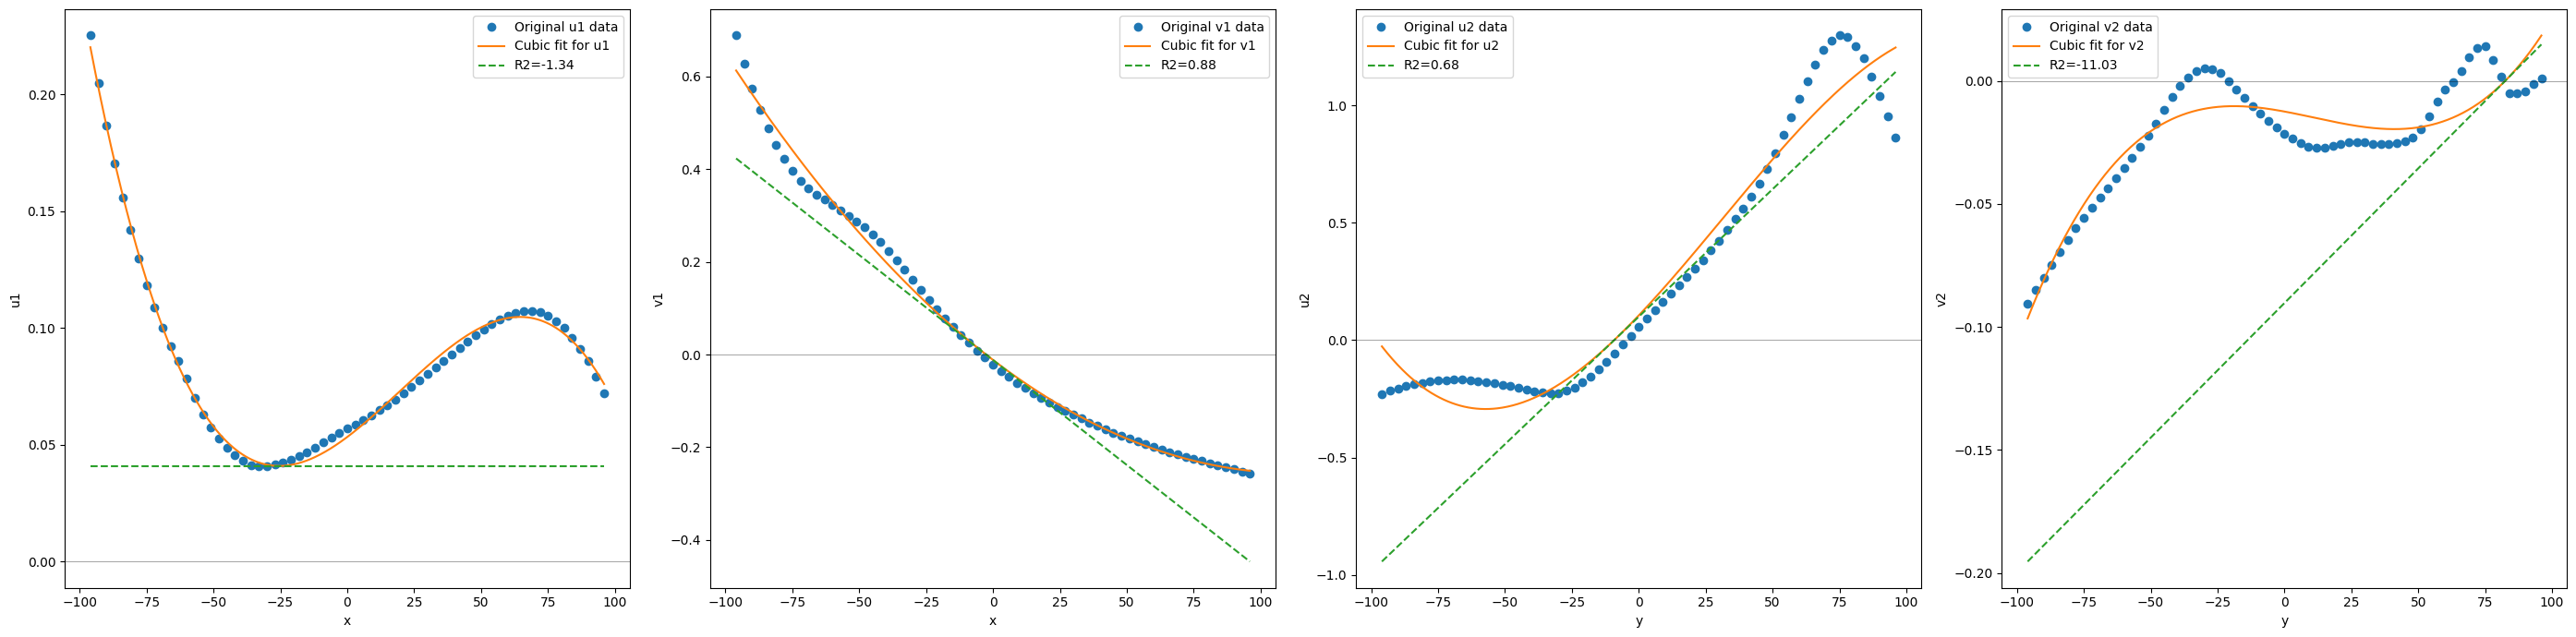

[-21.35715121] [-5.92109391]


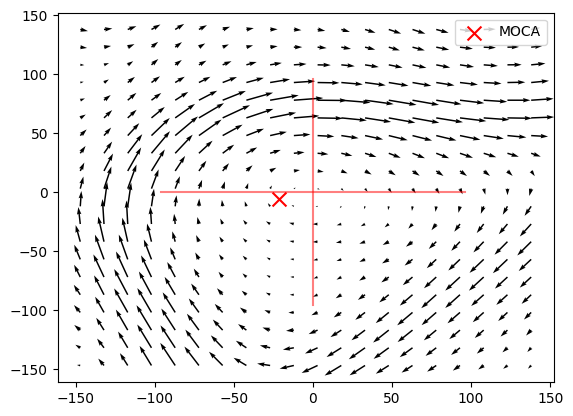

In [137]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 8, 6

vis(eddy, t, depth_lvl)

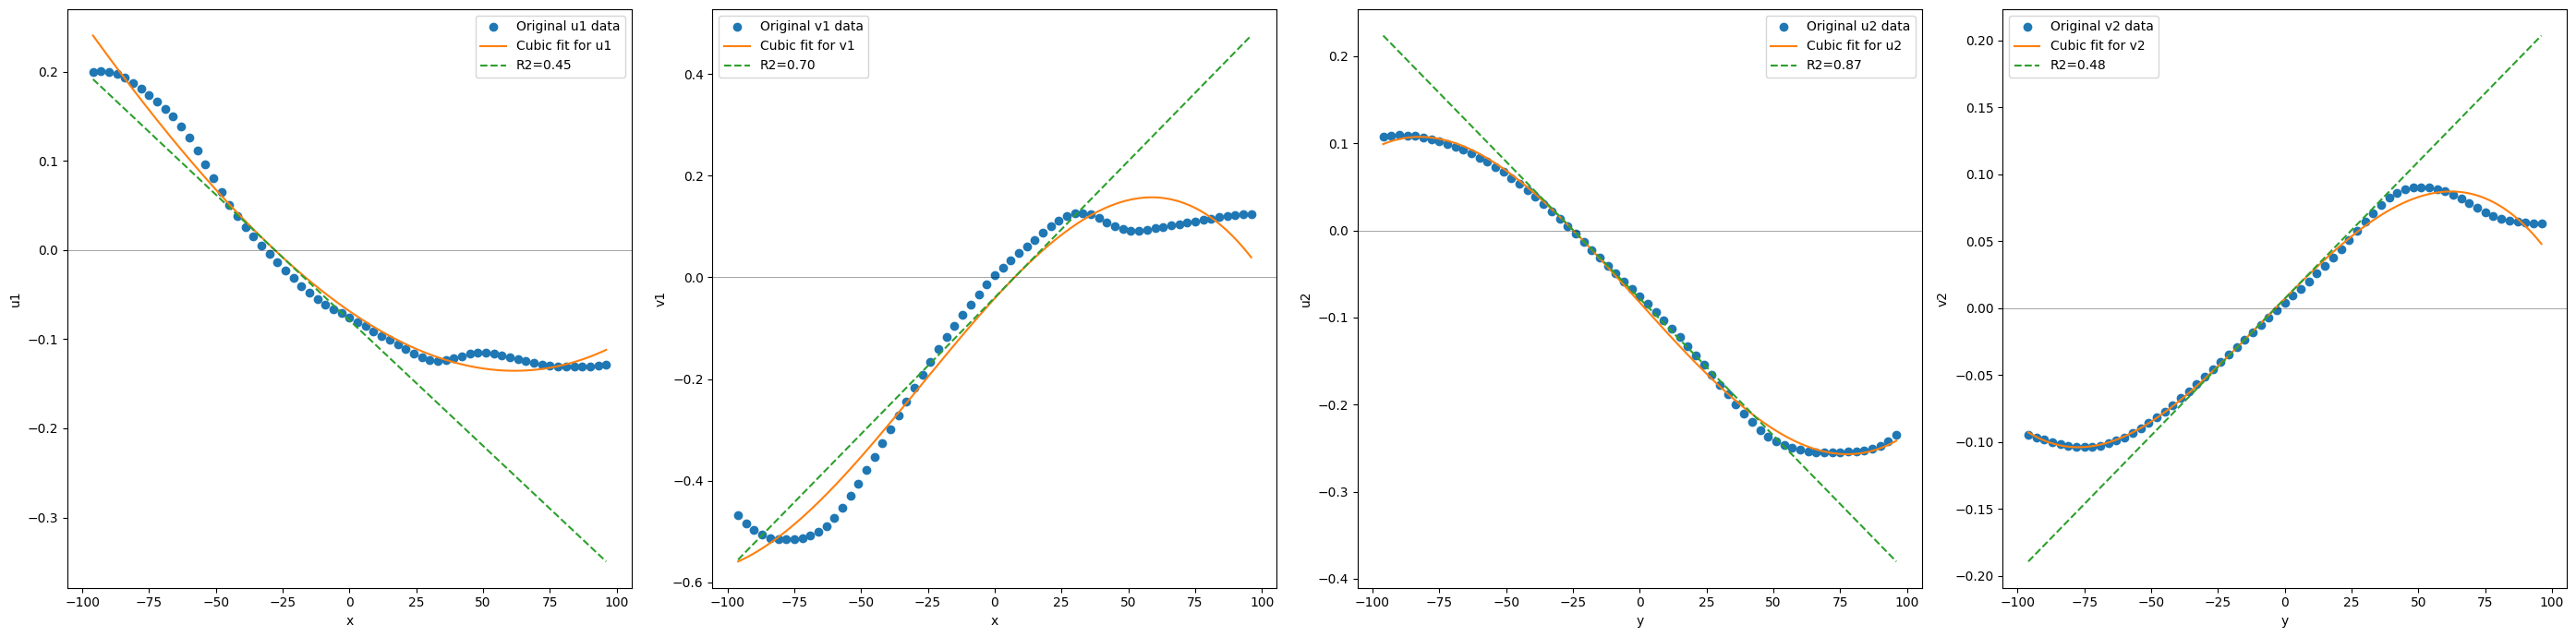

[22.33454479] [-45.07834385]


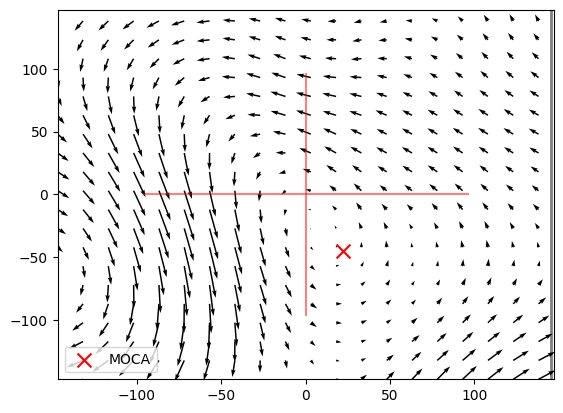

In [138]:
eddy = the_frontier_eddies[1]
t, depth_lvl = 8, 19

vis(eddy, t, depth_lvl)

In [123]:
def vis(eddy, t, depth_lvl):
    
    U, V, x, y = sample_data[eddy][f'T{t}']['U'], sample_data[eddy][f'T{t}']['V'], sample_data[eddy][f'T{t}']['x'], sample_data[eddy][f'T{t}']['y']
    X, Y, dx = *np.meshgrid(x, y), x[1] - x[0]
    var = -1 if eddies[eddy].iloc[0].Vort > 0 else 1
    xc_pre, yc_pre = 0, 0
    
    # Find nencioli
    u, v = U[:, :, depth_lvl], V[:, :, depth_lvl]

    nxc, nyc = 0, 0
    nic, njc = np.where(nxc == x)[0][0], np.where(nyc == y)[0][0]
    
    # Fit cubic and tangent
    def fit_cubic_and_tangent(x, y):
        cubic = np.poly1d(np.polyfit(x, y, 3))
        cubic_deriv = np.polyder(cubic)
        roots = np.roots(cubic)
        valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
    
        if valid_roots.size:
            R = np.abs(valid_roots-x[len(x)//2])
            root = valid_roots[R==np.min(R)]
            slope = cubic_deriv(root)
            intercept = -slope * root
        else:
            slope = 0
            roots = np.roots(cubic_deriv)
            valid_roots = roots[np.isreal(roots) & (min(x) <= roots) & (roots <= max(x))].real
            if valid_roots.size:
                R = np.abs(valid_roots-x[len(x)//2])
                root = valid_roots[R==np.min(R)]
                intercept = cubic(root)
            else:
                intercept = np.mean(y)
    
        tangent_line = slope * x + intercept
        sst = np.sum((y - np.mean(y))**2)
        sse = np.sum((y - tangent_line)**2)
        r_squared = 1 - (sse / sst)
    
        return slope, intercept, r_squared
    
    # Plot fits
    def extend_indices(arr, start_idx, r):
        indices = [start_idx]
        idx = start_idx
        i = 0
        while idx > 0 and not np.isnan(arr[idx - 1]):
            idx -= 1
            indices.insert(0, idx)
            if i > r:
                break
            i += 1
        idx = start_idx
        i = 0
        while idx < len(arr) - 1 and not np.isnan(arr[idx + 1]):
            idx += 1
            indices.append(idx)
            if i > r:
                break
            i += 1
        return indices
    
    r = 30 # 
    indices_1 = extend_indices(u[:, njc], nic, r)
    indices_2 = extend_indices(u[nic, :], njc, r)
    u1 = u[indices_1, njc]
    v1 = v[indices_1, njc]
    u2 = u[nic, indices_2]
    v2 = v[nic, indices_2]
    xx = x[indices_1] / 1000
    yy = y[indices_2] / 1000
    
    fig, axs = plt.subplots(1, 4, figsize=(28, 7))
    datasets = [(xx, u1, 'u1'),
                (xx, v1, 'v1'),
                (yy, u2, 'u2'),
                (yy, v2, 'v2')]
    
    for ax, (l, vel, label) in zip(axs, datasets):
        slope, intercept, r2 = fit_cubic_and_tangent(l, vel)
        l_fine = np.linspace(l.min(), l.max(), 500)
        ax.plot(l, vel, 'o', label=f'Original {label} data')
        ax.plot(l_fine, np.poly1d(np.polyfit(l, vel, 3))(l_fine), '-', label=f'Cubic fit for {label}')
        ax.plot(l_fine, slope * l_fine + intercept, '--', label=f'R2={r2:.2f}')
        ax.axhline(0, color='k', linestyle='-', linewidth=0.5, alpha=.5)
        ax.set_xlabel('x' if '1' in label else 'y')
        ax.set_ylabel(label)
        ax.legend()
    plt.tight_layout()
    plt.show()

    A1, A0, r2A = fit_cubic_and_tangent(xx, u1)
    B1, B0, r2B = fit_cubic_and_tangent(xx, v1)
    C1, C0, r2C = fit_cubic_and_tangent(yy, u2)
    D1, D0, r2D = fit_cubic_and_tangent(yy, v2)
    
    alpha = A0 if r2A < r2B else C0
    beta = B0 if r2B < r2D else D0
    gamma = A1 if r2A < r2D else -D1
    q11, q12, q22 = B1 / 2, -gamma / 2, -C1 / 2
    
    yc = (q11 * alpha + q12 * beta) / (2 * (q11 * q22 - q12 ** 2))  
    xc = (alpha * q12 + beta * q22) / (2 * (q12 ** 2 - q11 * q22))      
    w = 2 * (q11 + q22)
    
    # Plot results
    spacing = 5
    plt.quiver(X[::spacing, ::spacing]/1000, Y[::spacing, ::spacing]/1000, u[::spacing, ::spacing].T, v[::spacing, ::spacing].T)

    plt.plot(xx, [nyc/1000] *len(xx), 'r', zorder=1, alpha=.5)
    plt.plot([nxc/1000] * len(yy), yy, 'r', zorder=1, alpha=.5)

    if np.any(np.isnan(u)):
        nan_mask = np.isnan(u)
        mask = np.where(~np.isnan(u), np.nan, 0)
        plt.contourf(X/1000, Y/1000, mask.T, cmap='gray', zorder=-1)
        plt.contour(X/1000, Y/1000, nan_mask.T, colors='k', linewidths=2, alpha=.5)

    # plt.scatter(nxc/1000, nyc/1000, color='k', marker='x', label='Nenc')
    plt.scatter(xc, yc, color='r', marker='x', s=100, label='MOCA')
    plt.legend()
    print(xc, yc)

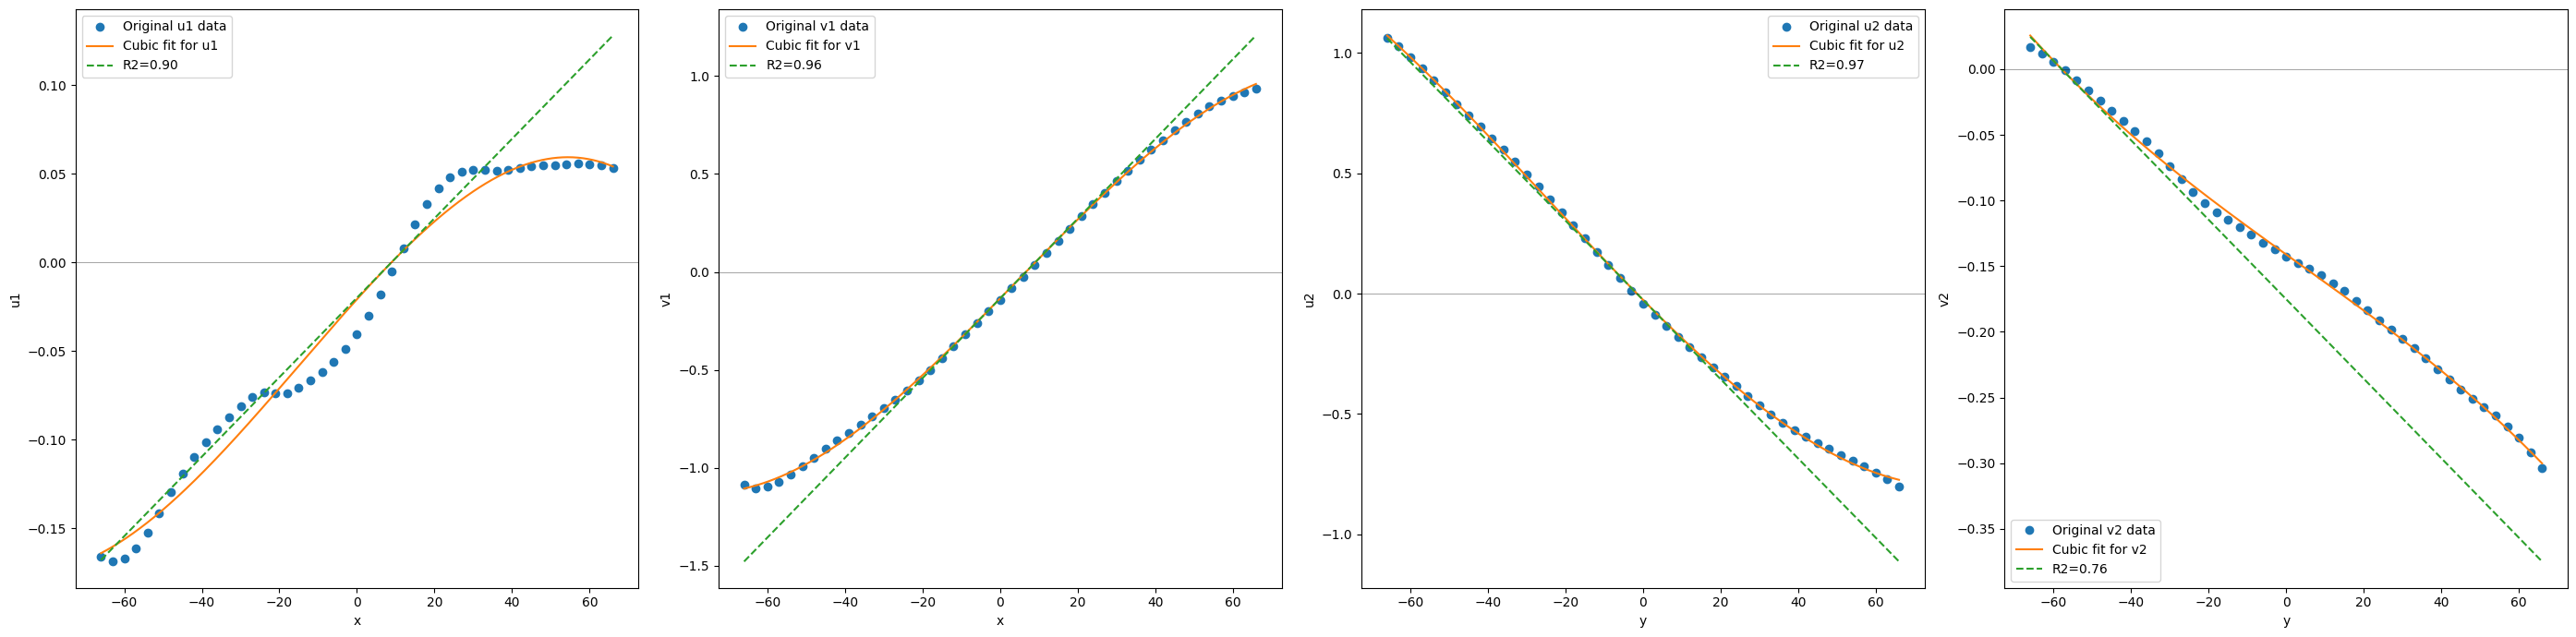

[8.66644123] [0.3776352]


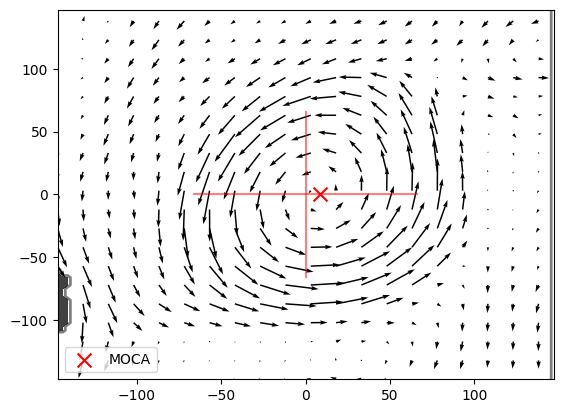

In [32]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 0, 0

vis(eddy, t, depth_lvl)

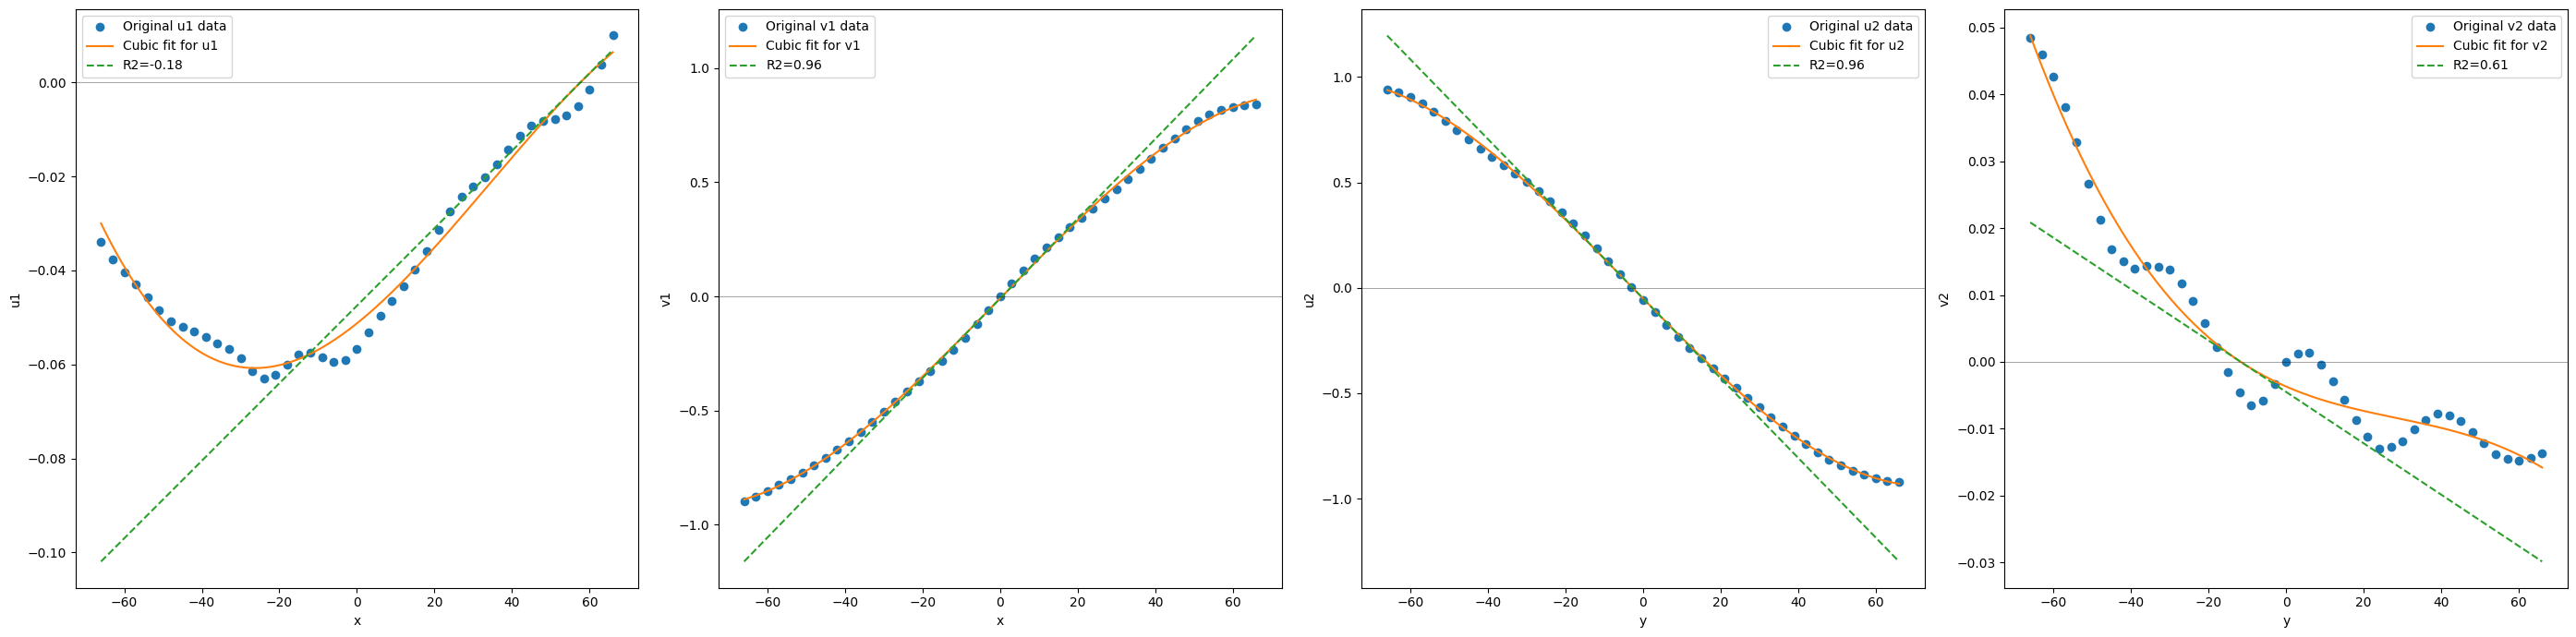

[0.13907393] [-2.50845001]


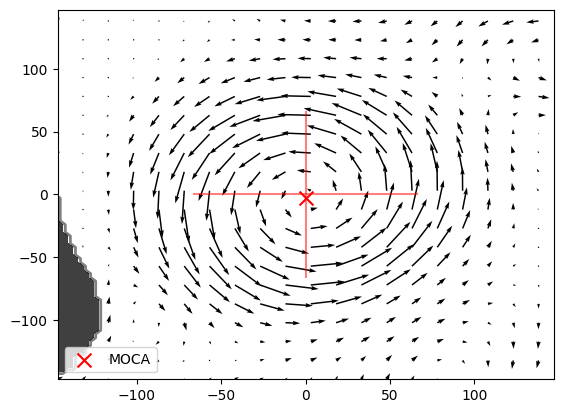

In [34]:
eddy = the_frontier_eddies[0]
t, depth_lvl = 15, 10

vis(eddy, t, depth_lvl)

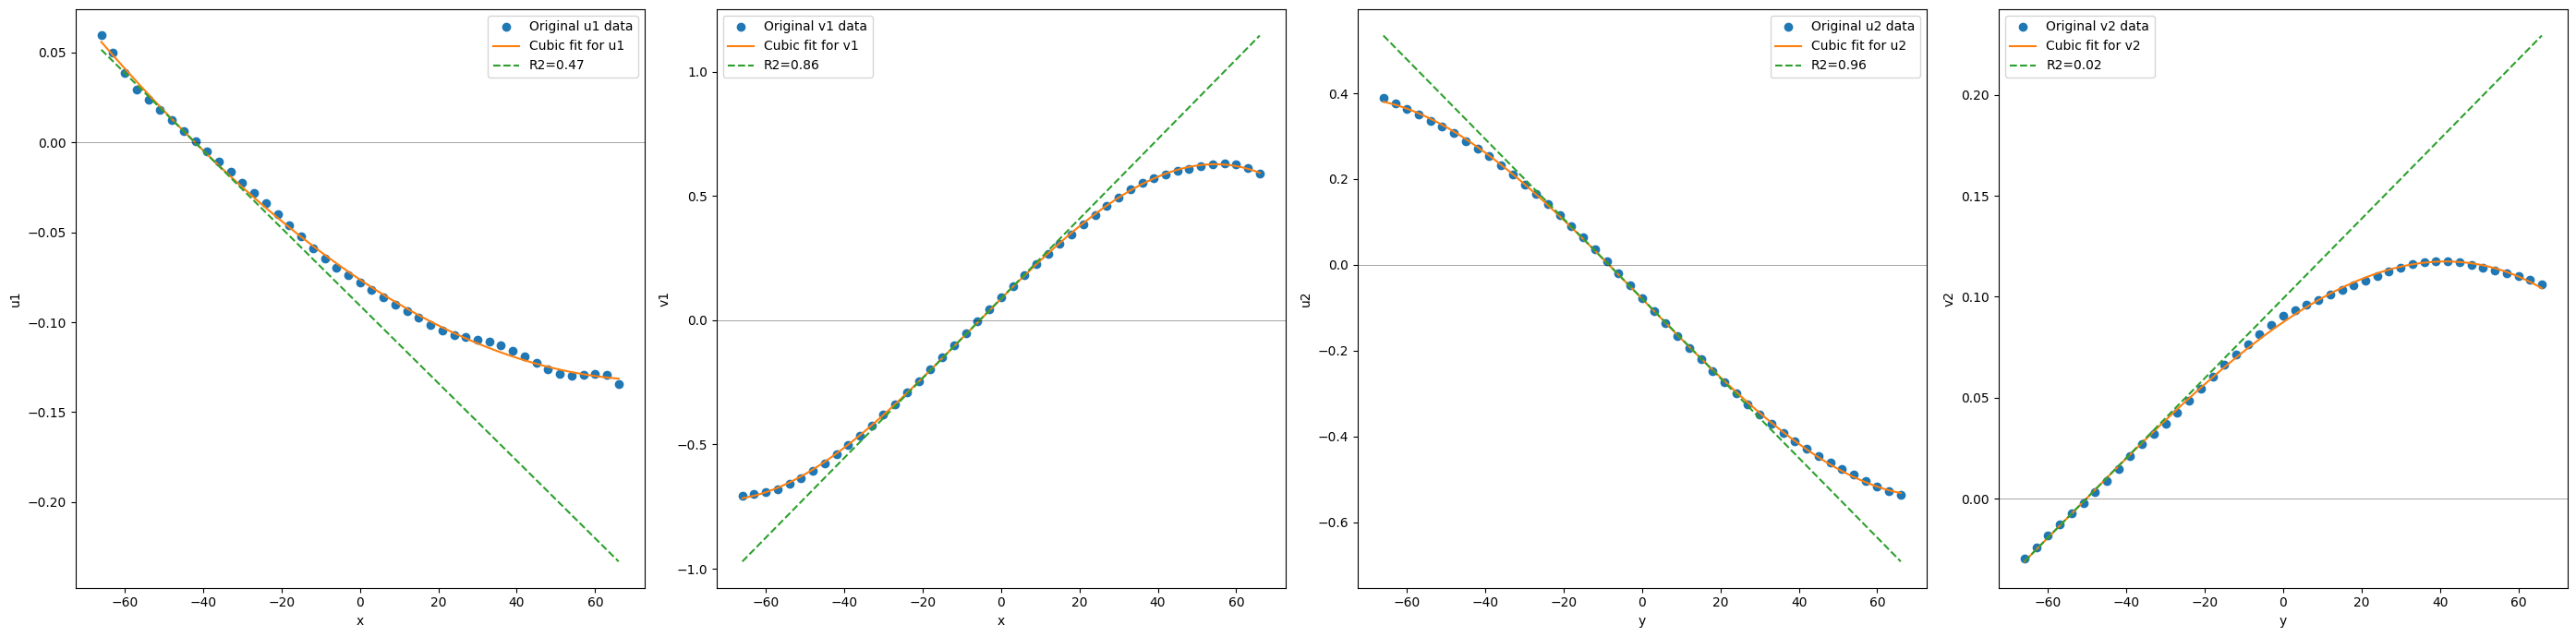

[-5.11393685] [-8.67838251]


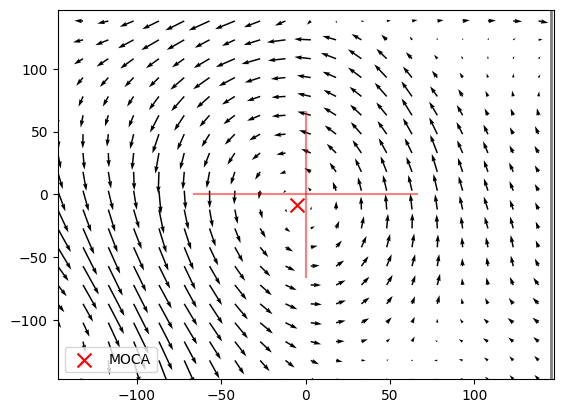

In [36]:
eddy = the_frontier_eddies[1]
t, depth_lvl = 0, 0

vis(eddy, t, depth_lvl)

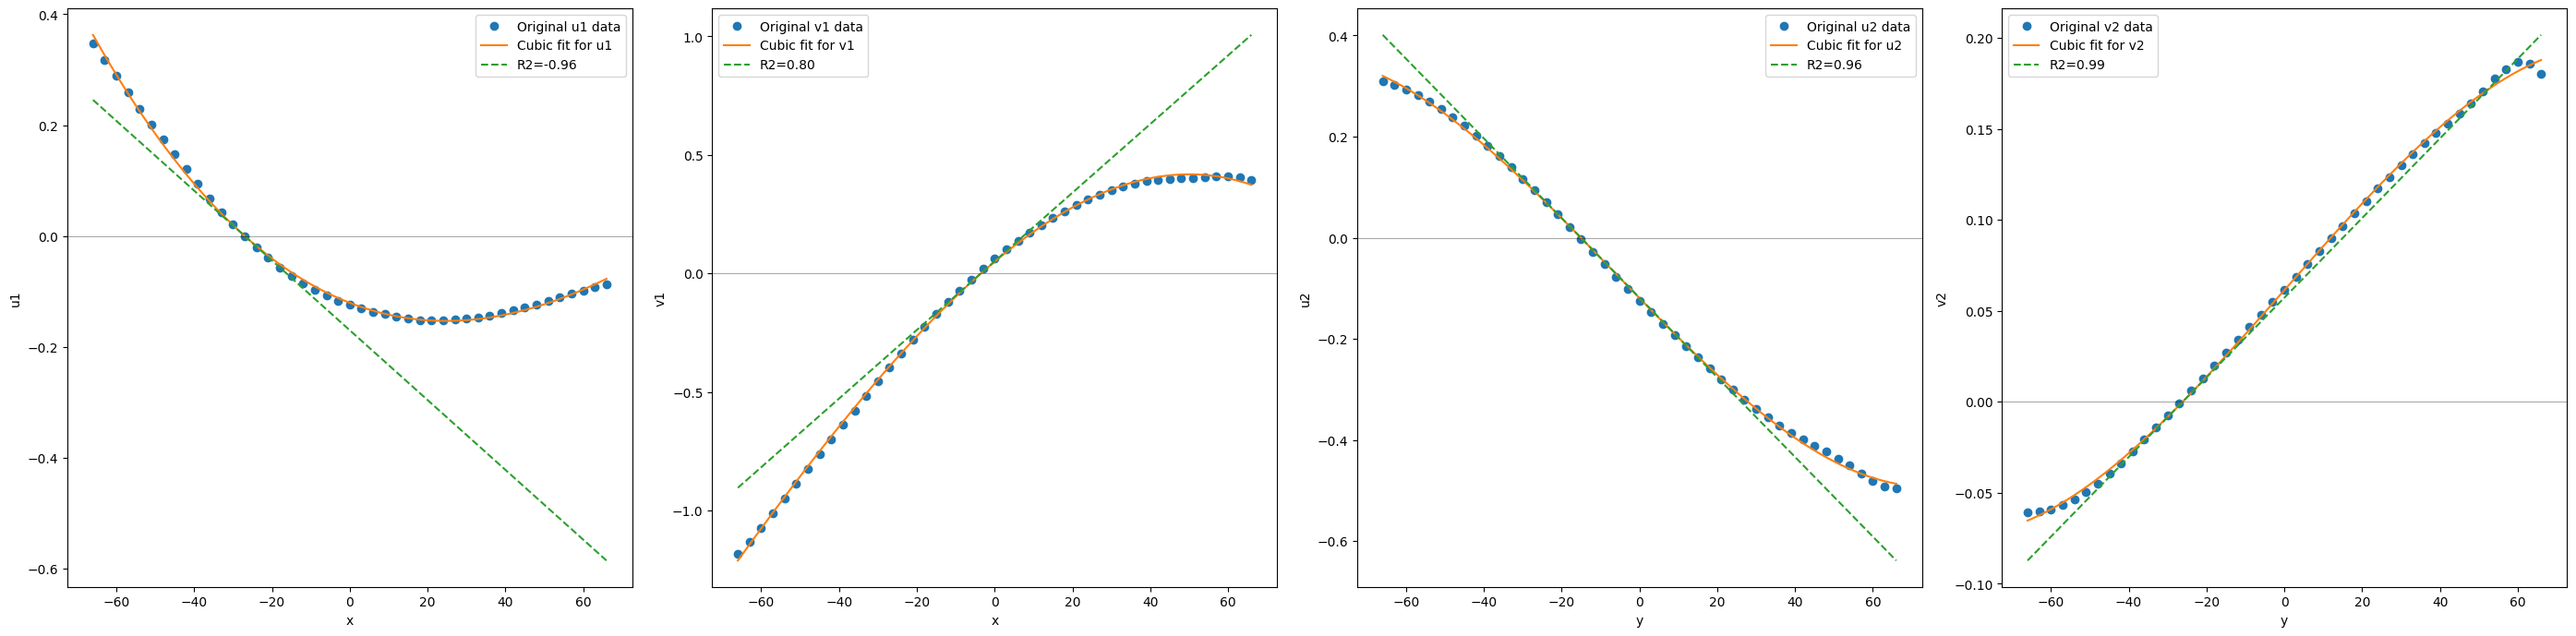

[8.96879959] [-28.71292287]


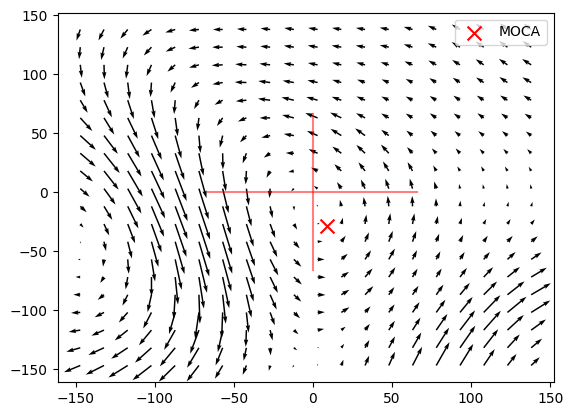

In [38]:
eddy = the_frontier_eddies[1]
t, depth_lvl = 10, 10

vis(eddy, t, depth_lvl)

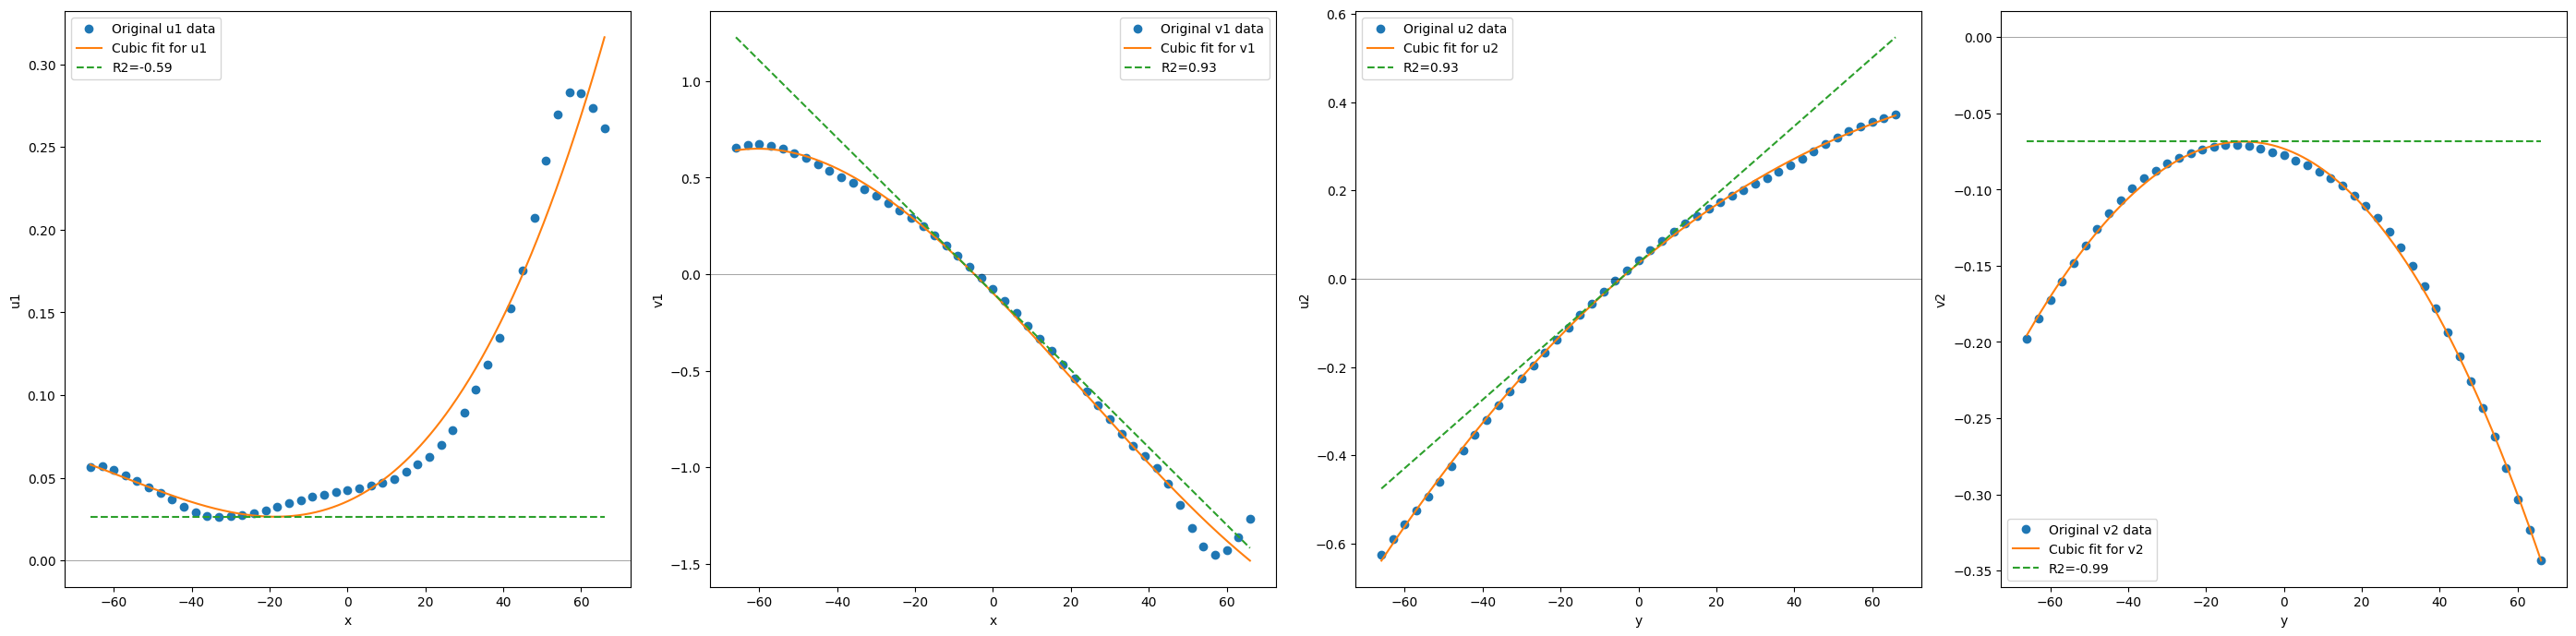

[-3.41516042] [-3.42949113]


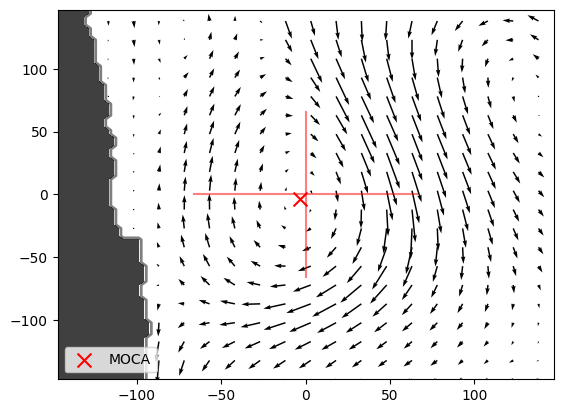

In [40]:
eddy = the_frontier_eddies[2]
t, depth_lvl = 10, 0

vis(eddy, t, depth_lvl)

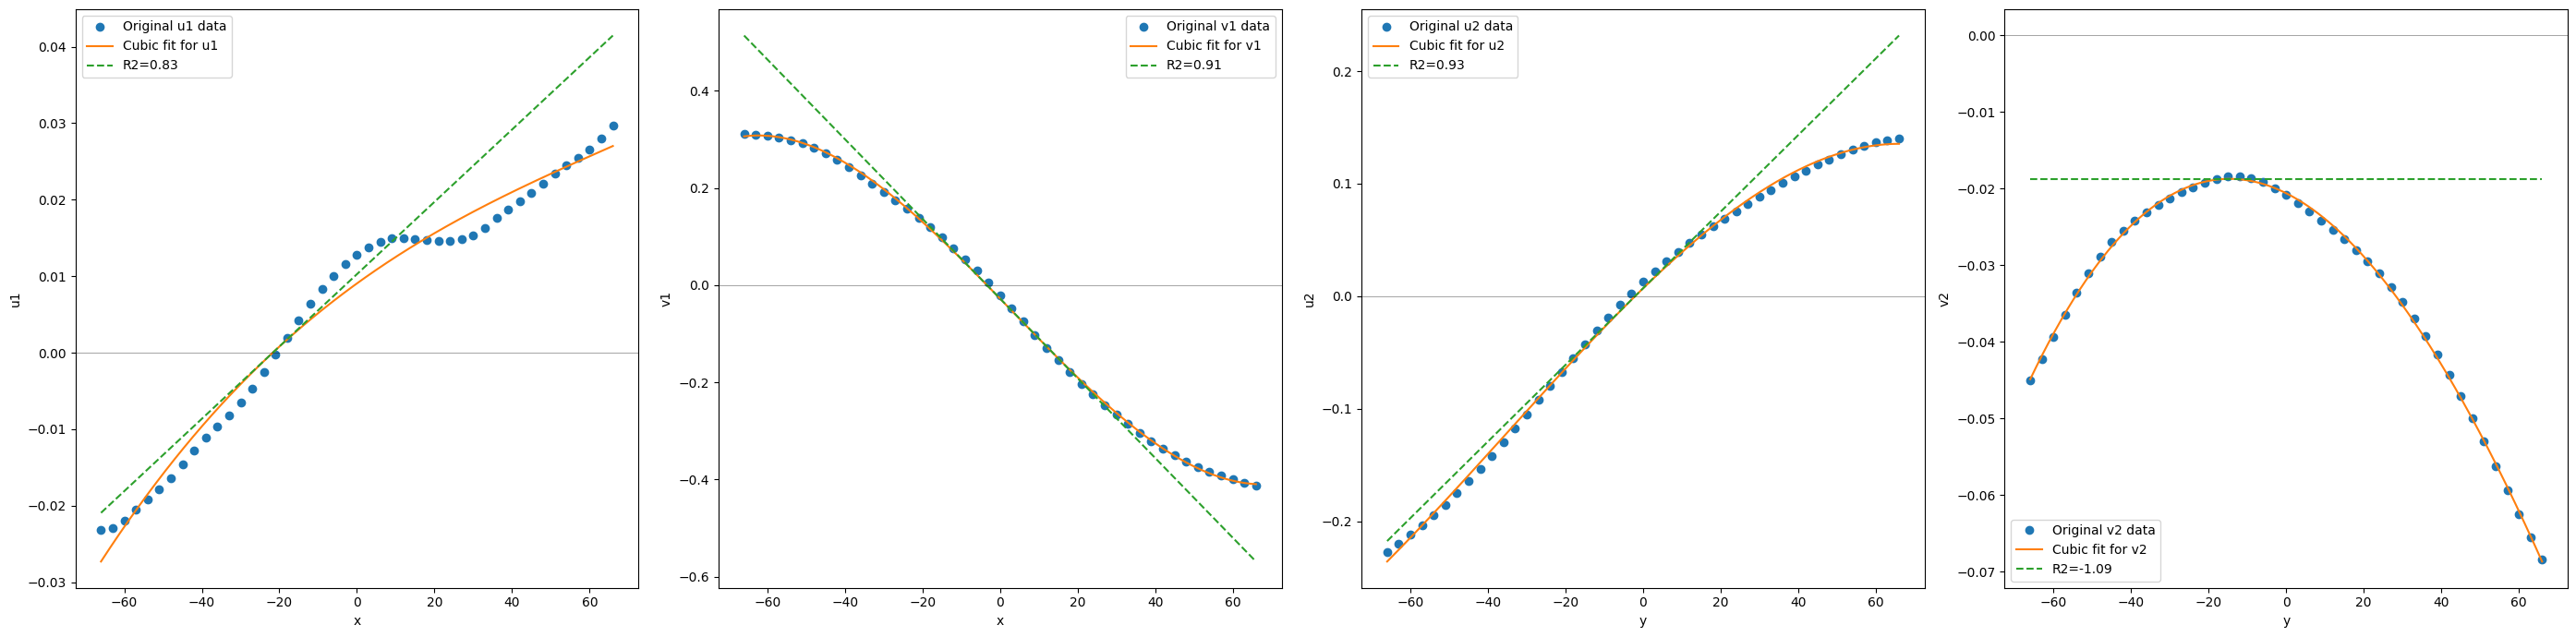

[-2.28222049] [-3.01638171]


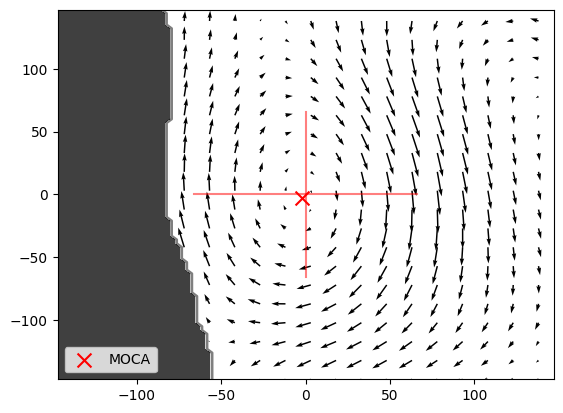

In [43]:
eddy = the_frontier_eddies[2]
t, depth_lvl = 10, 20

vis(eddy, t, depth_lvl)

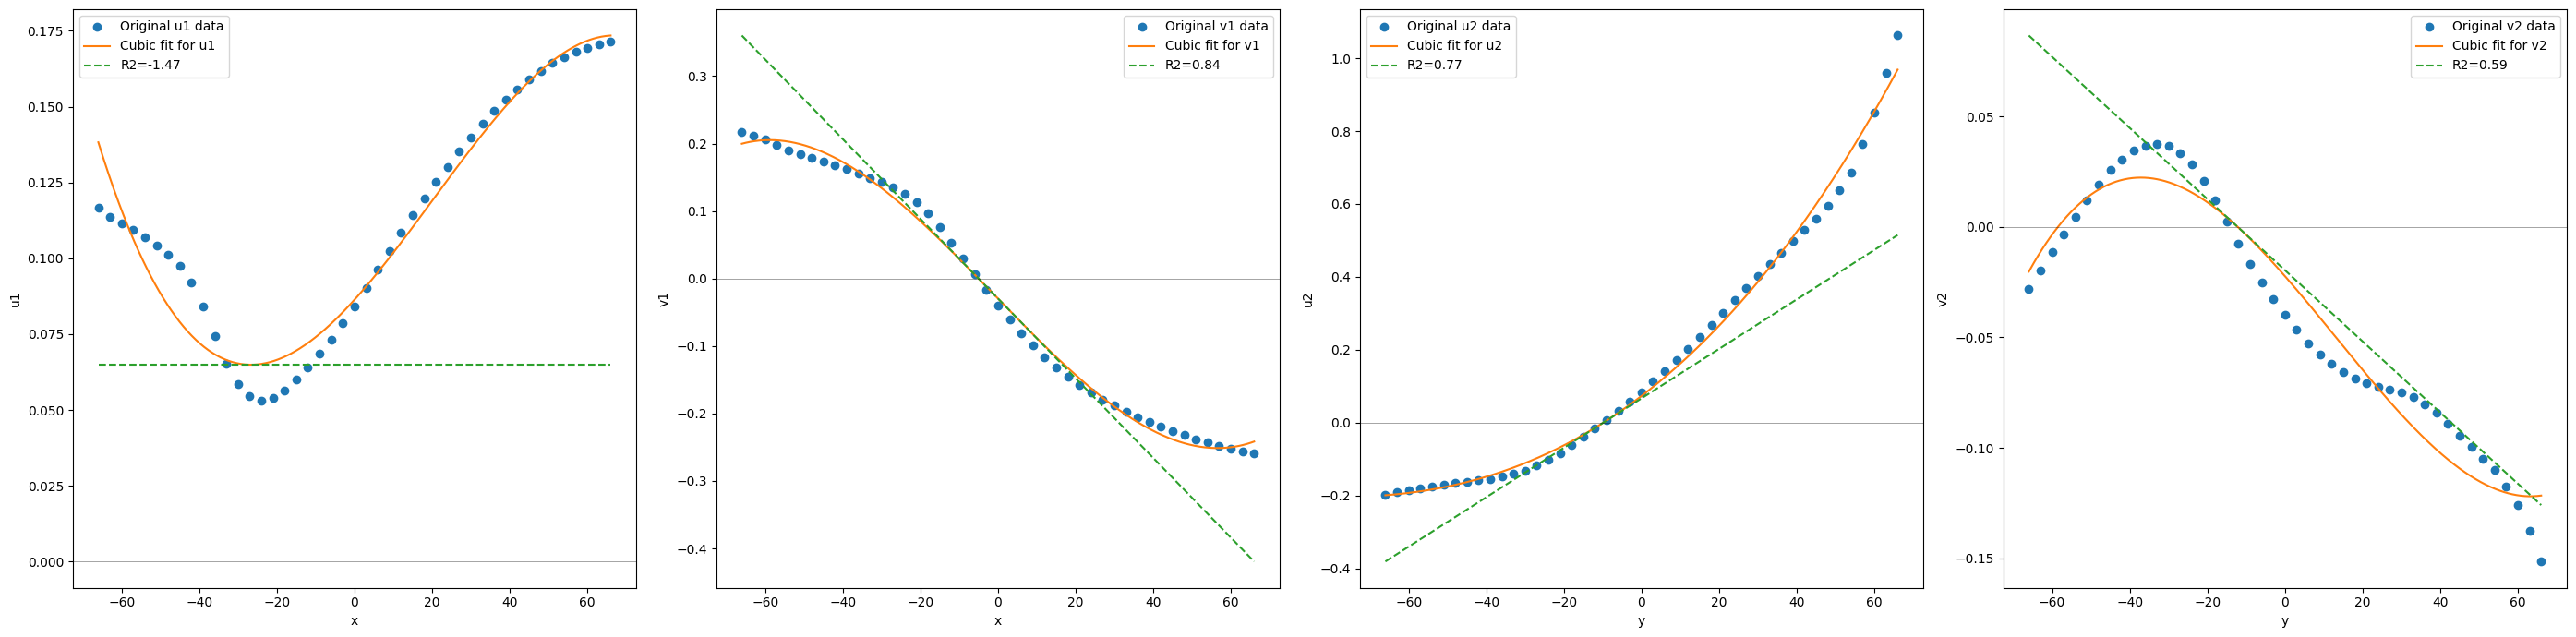

[-3.32619579] [-9.56218584]


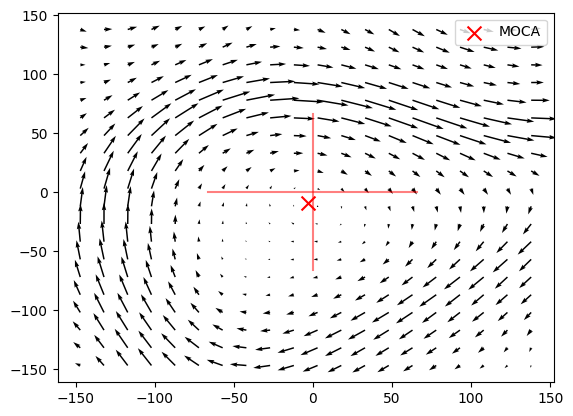

In [45]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 10, 0

vis(eddy, t, depth_lvl)

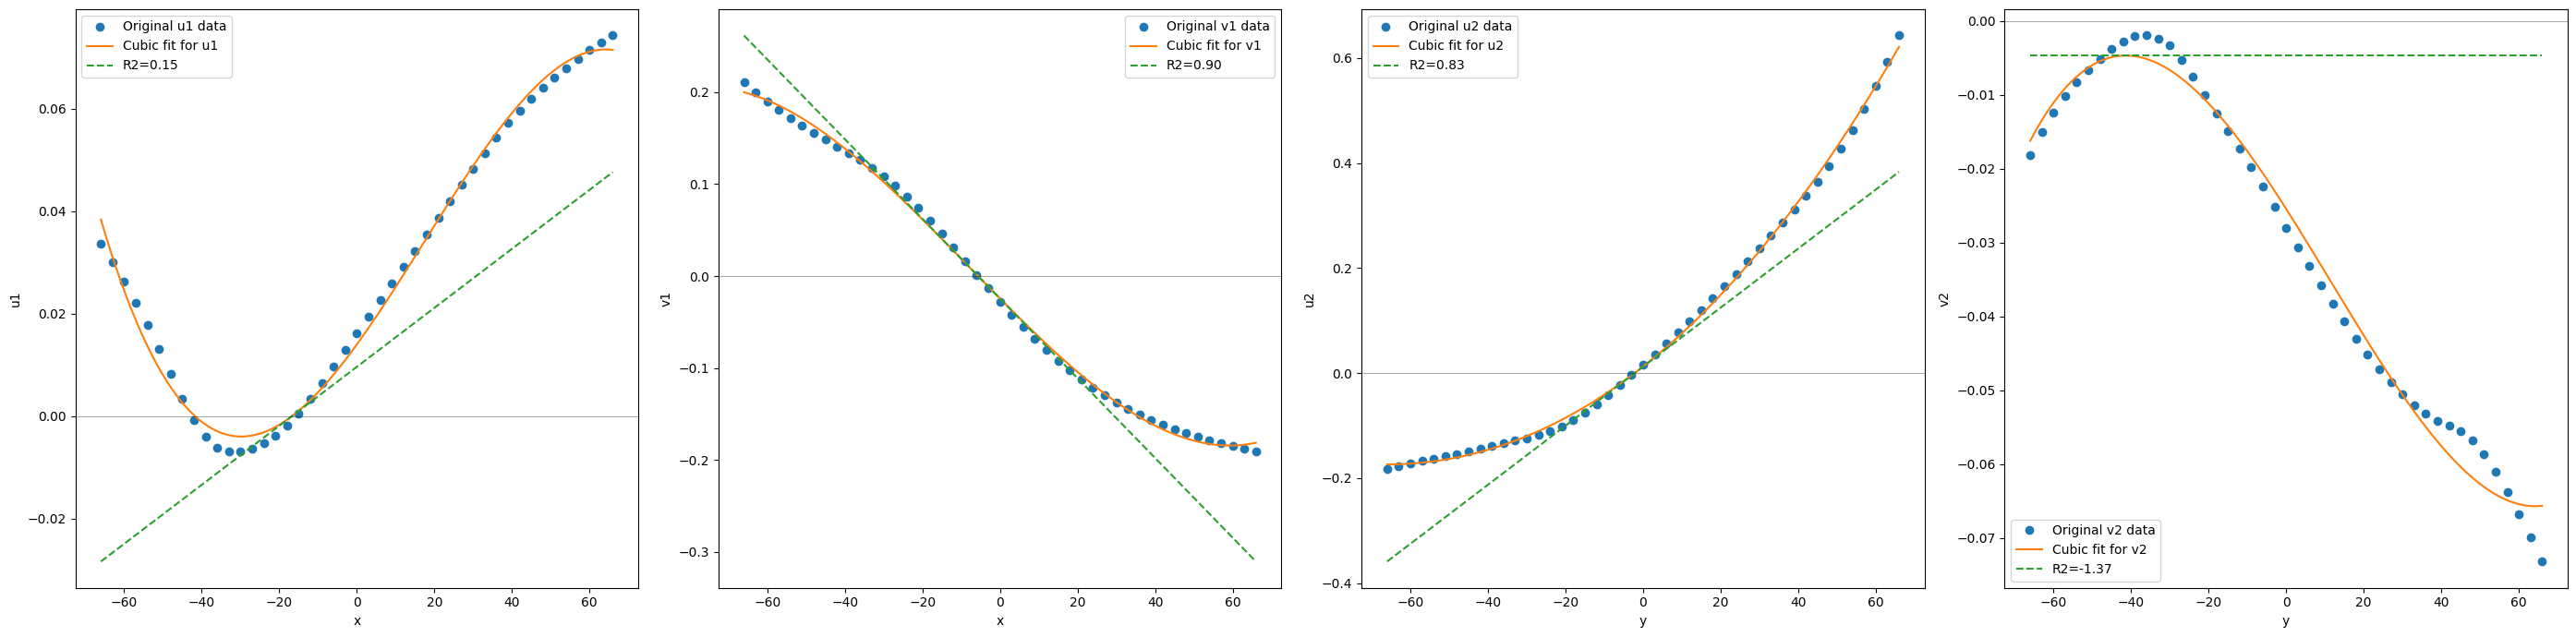

[-1.07550309] [-1.71771332]


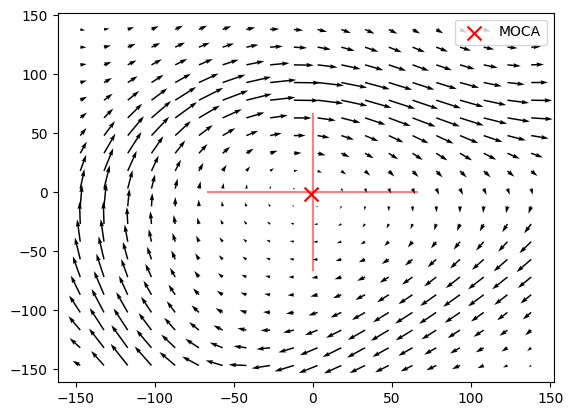

In [47]:
eddy = the_frontier_eddies[3]
t, depth_lvl = 10, 15

vis(eddy, t, depth_lvl)